In [1]:
import sys
sys.path.append('../')
from plot_config import *
plt.axes.labelweight = 'bold'
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
import tqdm
from scipy.optimize import curve_fit

In [2]:
# Simulation methods

def euler_sim(M, x0 ,dt, T, Perturbation=None):
    t_range = np.linspace(0, T, int(T/dt))[:-1]
    X = np.zeros((len(t_range)+1, 3), dtype=np.complex128)
    X[0] = x0
    # If statements outside the loop for performance!
    if Perturbation is not None:
        for i, t in enumerate(t_range):
            X[i+1] = X[i] - 1j*(M+Perturbation(t)) @ X[i]*dt
    else:
        for i, t in enumerate(t_range):
            X[i+1] = X[i] - 1j*dt*M @ X[i]

    return X

def rk4_sim(M, x0, dt, T, Perturbation=None):
    t_range = np.linspace(0, T, int(T/dt))[:-1]
    X = np.zeros((len(t_range)+1, 3), dtype=np.complex128)
    X[0] = x0
    if Perturbation is not None:
        for i, t in enumerate(t_range):
            k1 = -1j * (M+Perturbation(t)) @ X[i]
            k2 = -1j * (M+Perturbation(t+dt/2)) @ (X[i] + k1*dt/2)
            k3 = -1j * (M+Perturbation(t+dt/2)) @ (X[i] + k2*dt/2)
            k4 = -1j * (M+Perturbation(t+dt)) @ (X[i] + k3*dt)
            X[i+1] = X[i] + (k1 + 2*k2 + 2*k3 + k4)*dt/6
    else:
        for i, t in enumerate(t_range):
            k1 = -1j * M @ X[i]
            k2 = -1j * M @ (X[i] + k1*dt/2)
            k3 = -1j * M @ (X[i] + k2*dt/2)
            k4 = -1j * M @ (X[i] + k3*dt)
            X[i+1] = X[i] + (k1 + 2*k2 + 2*k3 + k4)*dt/6

    return X

def implicit_euler_sim(M,x0,dt , T, Perturbation = None):

    t_range = np.linspace(0, T, int(T/dt))[:-1]
    X = np.zeros((len(t_range)+1, 3), dtype=np.complex128)
    X[0] = x0
    if Perturbation is not None:
        for i, t in enumerate(t_range):
            X[i+1] = np.linalg.solve(np.eye(M.shape[0]) + 1j*dt*(M+Perturbation(t)), X[i])
    else:
        for i, t in enumerate(t_range):
            X[i+1] = np.linalg.solve(np.eye(M.shape[0]) + 1j*dt*M, X[i])


    return X

In [3]:
# Constants

from scipy.constants import physical_constants as pc
aut = pc['atomic unit of time'][0]
E = 200*1e-6 / pc['atomic unit of energy'][0] # uJ


tau_p = 5*1e-9 / aut # ns
t_0 = 10*1e-9 / aut # ns
w_0 = 0.5*1e-3 / pc['atomic unit of length'][0] # mm

mu_i_phi = np.sqrt(0.1)*0.15324673 # au
mu_i_psi = np.sqrt(0.2)*0.09692173 # au

E_i = 0
E_i_phi = 5000*1e2 * pc["atomic unit of length"][0] # cm^-1
E_i_psi = 5000*1e2 * pc["atomic unit of length"][0] # cm^-1
Gamma_diss = 25*1e2 * pc["atomic unit of length"][0] # cm^-1
g_phipsi = 0 # au

x0 = np.array([1, 0, 0]) # Initial state
dt = 0.0003e-9 / aut # ns
T = 20e-9 / aut # ns

omega_range = np.linspace(0.7*E_i_phi, 1.3*E_i_phi, 14) # cm^-1
num_threads_max = 7

PROJECT_DIR = os.path.dirname(os.path.abspath(''))
X_cache_dir = os.path.join(PROJECT_DIR, 'task3', 'x_cache')
os.makedirs(X_cache_dir, exist_ok=True)


In [199]:
# Fit a fano lineshape
def fano(omega, q, gamma_res, omega_res, c):
    epsilon = (omega-omega_res) / (gamma_res/2)
    return c + ((q+epsilon)**2) / (1+epsilon**2)
def fit_fano_lineshape(omega_range, intensities):
    popt, _ = curve_fit(fano, omega_range, intensities, p0=[1, 3e-2, 3.45e4*E_i_phi, 0], method='lm') #nvev=10000
    print(f'Optimized parameters:\n\t- q: {popt[0]}\n\t- gamma_res: {popt[1] / (100* pc['atomic unit of length'][0])} cm^-1\n\t- omega_res: {popt[2] / (100* pc['atomic unit of length'][0])} cm^-1\n\t- c: {popt[3]}')
    return popt

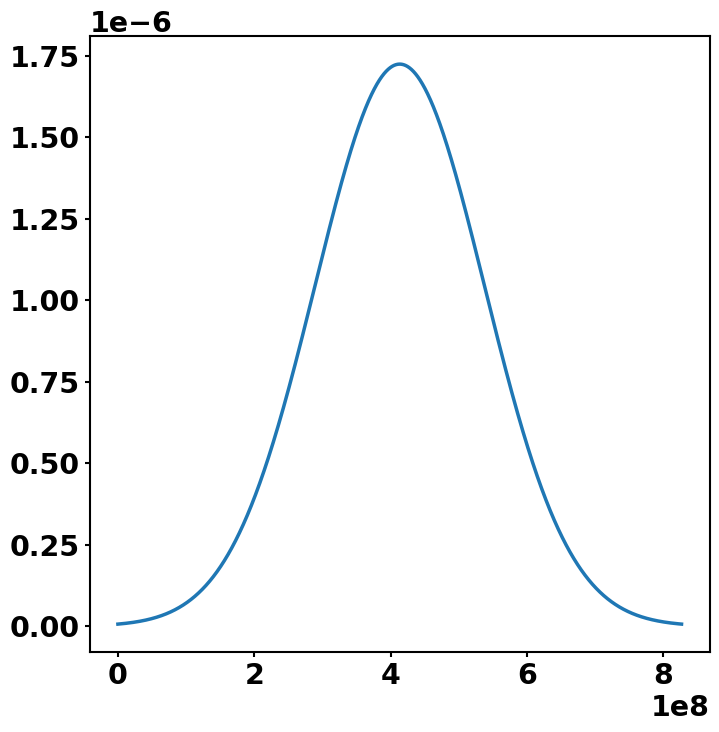

In [28]:
# Definitions of the laser -> coupling of the states
# tau_p = 5*1e-10 / aut # ns
t_range = np.linspace(0, T, int(T/dt))[:-1]
def intensity(t):
    return 2*E/(tau_p * np.pi* w_0**2)*2**(-4*((t-t_0)/(tau_p))**2)

def Omega_if(t, mu):
    return mu*np.sqrt(intensity(t))
plt.plot(t_range, Omega_if(t_range, mu_i_psi))
plt.show()

In [184]:
import h5py

def calc_dissoc_yield(omega, g_phipsi, E_psi_zero=False, mod_gamma_diss=False):
    # Check if the file is already computed
    x_cache_path = os.path.join(X_cache_dir, f'dt_{round(dt)}', f'g_{g_phipsi}', f'omega_{str(omega*1e10)}.h5')
    if E_psi_zero:
        x_cache_path = x_cache_path.replace('.h5', '_E_psi_zero.h5')
    if mod_gamma_diss:
        x_cache_path = x_cache_path.replace('.h5', f'_gamma_{Gamma_diss}.h5')
    os.makedirs(os.path.dirname(x_cache_path), exist_ok=True)
    if os.path.isfile(x_cache_path):
        with h5py.File(x_cache_path, 'r') as hf:
            # Check all the parameters, otherwise recompute
            if hf.attrs['omega'] == omega and hf.attrs['dt'] == dt and hf.attrs['T'] == T and hf.attrs['t_0'] == t_0 and hf.attrs['tau_p'] == tau_p and hf.attrs['w_0'] == w_0 and hf.attrs['E'] == E and np.all(hf.attrs['x0'] == x0) and hf.attrs['mu_i_phi'] == mu_i_phi and hf.attrs['mu_i_psi'] == mu_i_psi and hf.attrs['E_i'] == E_i and hf.attrs['E_i_phi'] == E_i_phi and hf.attrs['E_i_psi'] == E_i_psi and hf.attrs['Gamma_diss'] == Gamma_diss and hf.attrs['g_phipsi'] == g_phipsi:
                X = hf['X'][:]
                dissoc_yield = 1 - np.abs(X[-1,0])**2
                # print(f'Loaded from cache {x_cache_path}: omega = {omega}, dissoc_yield = {dissoc_yield}')
                return omega, dissoc_yield

    E_phi = E_i_phi - omega
    if E_psi_zero:
        E_psi = -1j* Gamma_diss/2
    else:
        E_psi = E_i_psi - omega - 1j* Gamma_diss/2

    # laser
    laser = lambda t: np.array(
        [
            [0, np.conjugate(Omega_if(t,mu_i_phi))/2, np.conjugate(Omega_if(t,mu_i_psi))/2],
            [Omega_if(t,mu_i_phi)/2, 0, 0],
            [Omega_if(t,mu_i_psi)/2, 0, 0],
        ]
    )

    M = np.array(
        [
            [E_i, 0,0],
            [0, E_phi, np.conjugate(g_phipsi)/2],
            [0, g_phipsi/2, E_psi],
        ]
    )

    X = rk4_sim(M=M, x0=x0, dt=dt, T=T, Perturbation=laser)

    # Save with HDF5 (better than .txt for large arrays)
    with h5py.File(os.path.join(x_cache_path), 'w') as hf:
        # Save the array
        hf.create_dataset('X', data=X)
        # Save all the parameters
        hf.attrs['omega'] = omega
        hf.attrs['dt'] = dt
        hf.attrs['T'] = T
        hf.attrs['t_0'] = t_0
        hf.attrs['tau_p'] = tau_p
        hf.attrs['w_0'] = w_0
        hf.attrs['E'] = E
        hf.attrs['x0'] = x0
        hf.attrs['mu_i_phi'] = mu_i_phi
        hf.attrs['mu_i_psi'] = mu_i_psi
        hf.attrs['E_i'] = E_i
        hf.attrs['E_i_phi'] = E_i_phi
        hf.attrs['E_i_psi'] = E_i_psi
        hf.attrs['Gamma_diss'] = Gamma_diss
        hf.attrs['g_phipsi'] = g_phipsi
    # Take the maximum of the last part, as sometimes the simulation is not stable because the real and imaginary parts are not in phase
    dissoc_yield = 1 - np.abs(X[-1,0])**2
    return omega, dissoc_yield

Calculating for 3 specific omegas and g=0 a.u., dt=0.0003 ns, T=20.0 ns:
For omega = 7.937658163545e-06: dissoc_yield = 0.06052028178946989
For omega = 2.3812974490635e-05: dissoc_yield = 0.8801604267801789
For omega = 2.645886054515e-05: dissoc_yield = 0.999999994291585


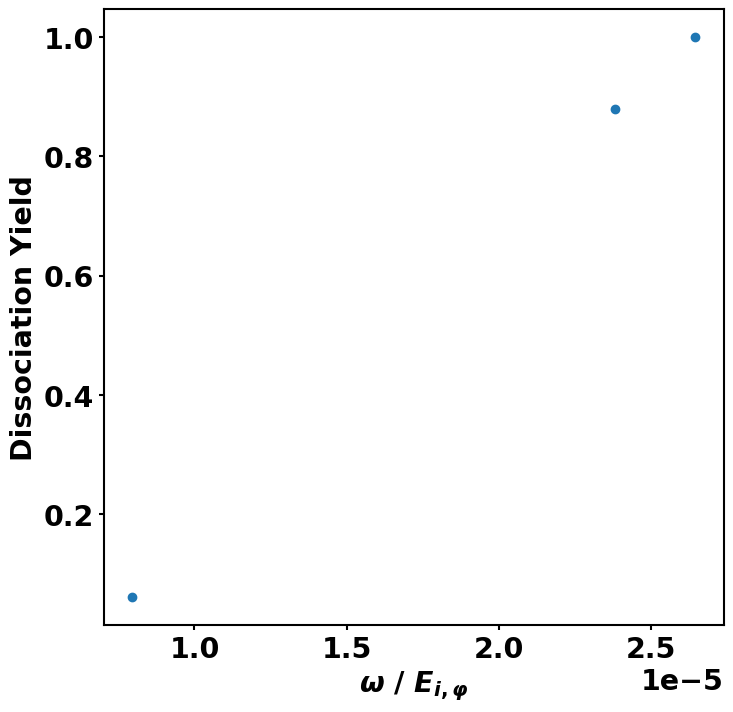

(66666, 3) (66666,)
(66666, 3) (66666,)
(66666, 3) (66666,)


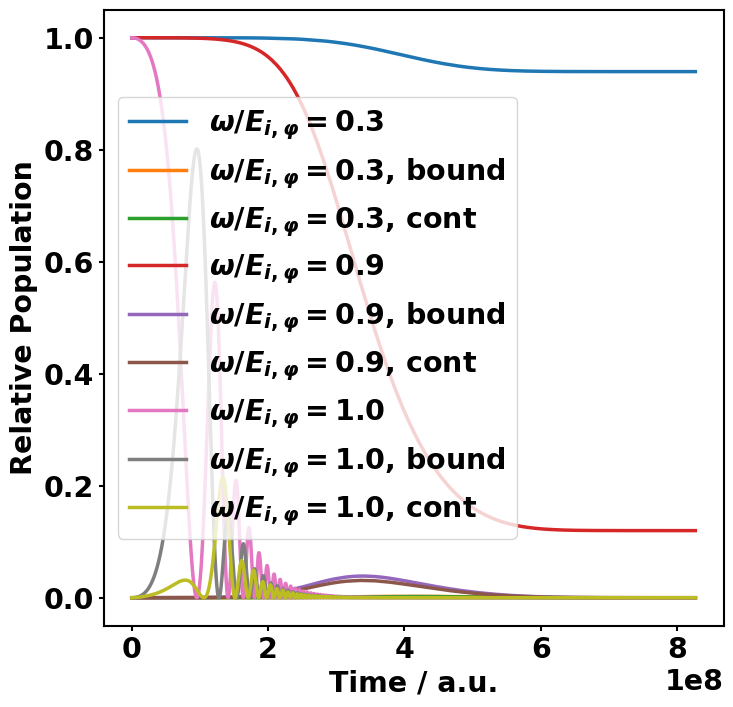

In [7]:
# Calculate X for 3 specific omegas to get a feeling for the accuracy
# Far off resonant, resonant, and close to resonant

print(f'Calculating for 3 specific omegas and g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns:')
omega_range_test = [0.3*E_i_phi, 0.9*E_i_phi, E_i_phi]

dissoc_yields = []
for omega in omega_range_test:
    omega, dissoc_yield = calc_dissoc_yield(omega, g_phipsi)
    dissoc_yields.append(dissoc_yield)
    print(f'For omega = {omega}: dissoc_yield = {dissoc_yield}')

# Plot the resulting yield
plt.plot(omega_range_test, dissoc_yields, 'o')
plt.xlabel(r'$\omega$ / $E_{i,\varphi}$')
plt.ylabel('Dissociation Yield')
plt.show()

# Show the initial state population evolution for all cases
for omega in omega_range_test:
    x_cache_path = os.path.join(X_cache_dir, f'dt_{round(dt)}', f'g_{g_phipsi}', f'omega_{str(omega*1e10)}.h5')
    with h5py.File(x_cache_path, 'r') as hf:
        X = hf['X'][:]
        t_range = np.linspace(0, T, int(T/dt))
        print(X.shape, t_range.shape)
        plt.plot(t_range, np.abs(X[:,0])**2, label=r'$\omega / E_{i, \varphi} = ' + str(round(omega/E_i_phi, 2)) + '$')
        plt.plot(t_range, np.abs(X[:,1])**2, label=r'$\omega / E_{i, \varphi} = ' + str(round(omega/E_i_phi, 2)) + '$, bound')
        plt.plot(t_range, np.abs(X[:,2])**2, label=r'$\omega / E_{i, \varphi} = ' + str(round(omega/E_i_phi, 2)) + '$, cont')
plt.xlabel('Time / a.u.')
plt.ylabel('Relative Population')
plt.legend()
plt.show()

From this we can see that after $T = 20$ ns, equilibrium is reached and a timestep of $dt = 0.0003$ ns is sufficient to obtain stable results. So we continue with these parameters.

In [8]:
start_omega = np.linspace(0, 0.825*E_i_phi, 15)
# Here the more interesting stuff happens -> sample more densely
intermediate_omega = np.linspace(0.8*E_i_phi, 1.1*E_i_phi, 100)
end_omega = np.linspace(1.1*E_i_phi, 1.5*E_i_phi, 10)
omega_range = np.concatenate([start_omega, intermediate_omega, end_omega])
num_threads_max = 10
print(f'Number of simulations: {len(omega_range)}, dt: {dt*aut*1e9} ns, g: {g_phipsi} a.u., T: {T*aut*1e9} ns, num_simulations/num_threads: {len(omega_range)/num_threads_max}')


Number of simulations: 125, dt: 0.0003 ns, g: 0 a.u., T: 20.0 ns, num_simulations/num_threads: 12.5


In [174]:
# Calculate the spectra using multiple threads

def simulate_plot_spectrum(g_phipsi, omega_range, E_psi_zero=False, mod_gamma_diss=False, fit_fano=False):
    dissoc_yields = {}

    with ProcessPoolExecutor(max_workers=num_threads_max) as executor:
        futures = {executor.submit(calc_dissoc_yield, omega, g_phipsi, E_psi_zero, mod_gamma_diss): omega for omega in omega_range}
        counter = 0
        for future in tqdm.tqdm(as_completed(futures), total=len(omega_range)):
            omega, dissoc_yield = future.result()
            dissoc_yields[omega] = dissoc_yield
            counter += 1
            # print(f'Finished ({counter}/{len(omega_range)}) for omega/E_i_phi={omega/E_i_phi}, dissoc_yield={dissoc_yield}')
    # Plot the results
    omega_range_plot = np.array([float(omega)/E_i_phi for omega in dissoc_yields.keys()])
    plt.plot(omega_range_plot, list(dissoc_yields.values()), ls='', marker='o',label='Simulation')
    # Fit the results to a Fano line shape
    if fit_fano:
        q, gamma_res, omega_res, c = fit_fano_lineshape(omega_range_plot, list(dissoc_yields.values()))
        # print(fano(omega_range_plot, q, gamma_res, omega_res, c))
        plt.plot(omega_range_plot, fano(omega_range_plot, q, gamma_res, omega_res, c), label='Fano Fit')
        plt.legend()
    plt.xlabel(r"$\omega$ / $E_{i \varphi}$")
    plt.ylabel("Dissociation Yield")
    plt.show()

Starting spectrum simulation for g=0 a.u., dt=0.0003 ns, T=20.0 ns


100%|██████████| 125/125 [00:00<00:00, 660.93it/s]


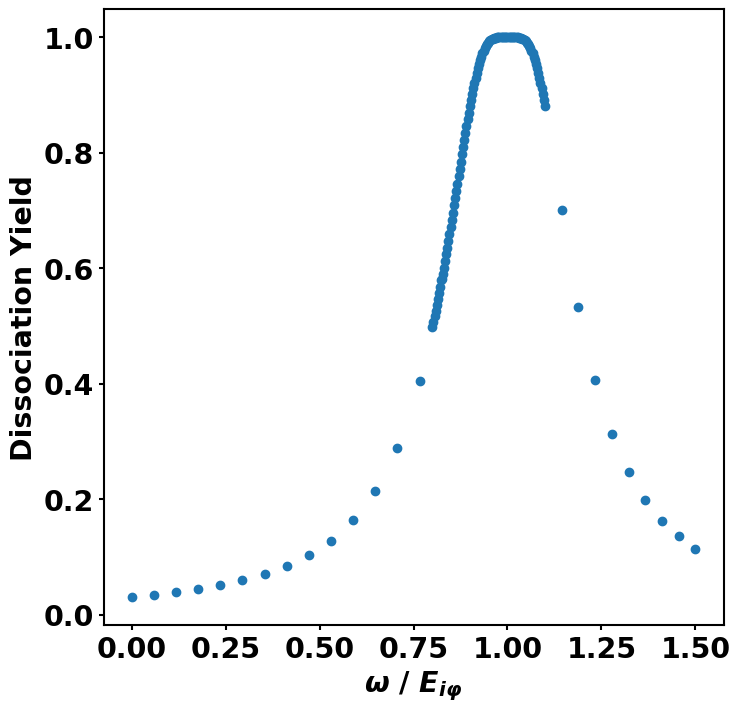

In [10]:
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns')
simulate_plot_spectrum(g_phipsi, omega_range)

This is obviously not a Fano-lineshape, but it was also not expected, as the interaction $g_{i, \varphi}$ was set to zero. The Fano-lineshape is a result of the interference of two different decay channels, which is not present in this case.

Starting spectrum simulation for g=0 a.u., dt=0.0003 ns and (detuned) E_psi=0


100%|██████████| 125/125 [00:00<00:00, 1318.68it/s]


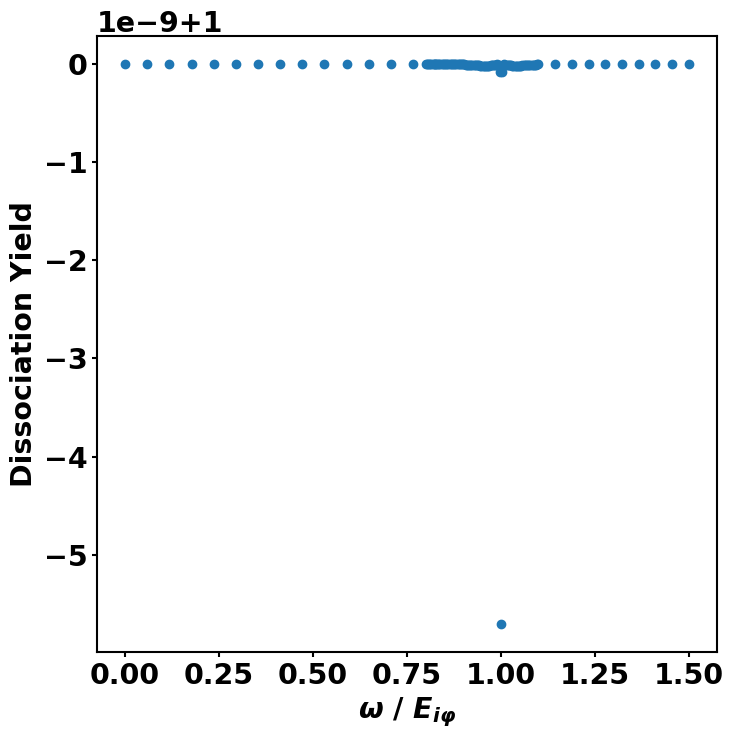

In [11]:
# Manually set the detuning of the continuum to 0
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns and (detuned) E_psi=0')
simulate_plot_spectrum(g_phipsi, omega_range, E_psi_zero=True)

The result shows that at any laser frequency, all population is lost, as the population yield is 1 at any $\omega$ (Note the weird scale by matplotlib, it is 1e-9+1, 0 on the axis label is at dissociation yield = 1). To make sure that the drop at $\omega = E_{i, \varphi}$ is not a numerical artefact, lets test with a smaller timestep $dt = 0.00005$ ns.

This result makes physically sense, as the continuum can be excited at any frequency and the population will be lost.

In [12]:
# # More accurate calculation to get rid of artifacts
# dt = 0.00005e-9 / aut # ns
# print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns and (detuned) E_psi=0')
# simulate_plot_spectrum(g_phipsi, omega_range, E_psi_zero=True)
# # Reset dt
# dt = 0.0003e-9 / aut # ns

We can still see a drop in dissociation yield at $\omega = E_{i, \varphi}$. The drop in dissociation yield also makes sense, as when exciting into the bound state, a small bit less of the population is available for the dissociation through the continuum.

Starting spectrum simulation for g=0 a.u., dt=0.0003 ns and gamma_diss=1000.0 cm^-1
Detuning E_phi not set to 0


100%|██████████| 125/125 [00:00<00:00, 1210.06it/s]


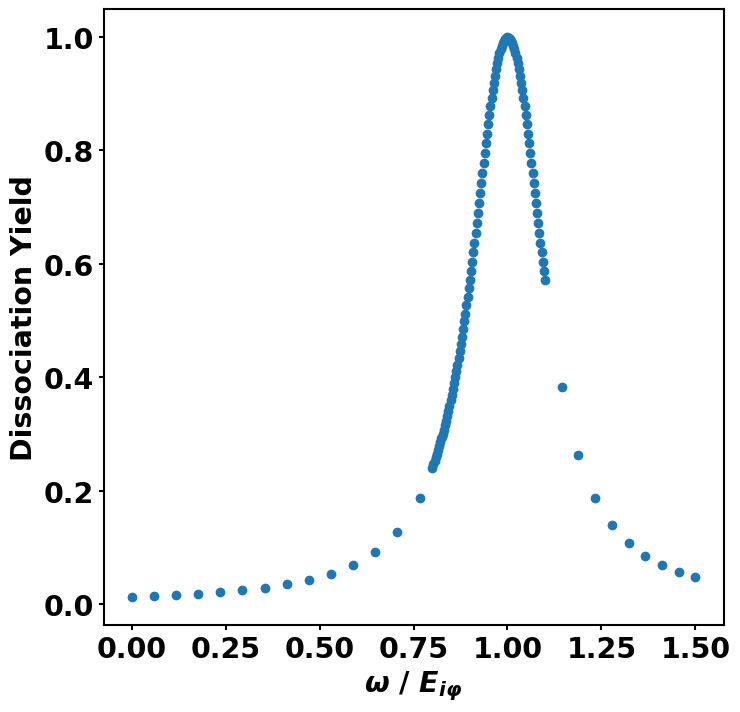

Detuning E_phi set to 0


100%|██████████| 125/125 [00:00<00:00, 1228.78it/s]


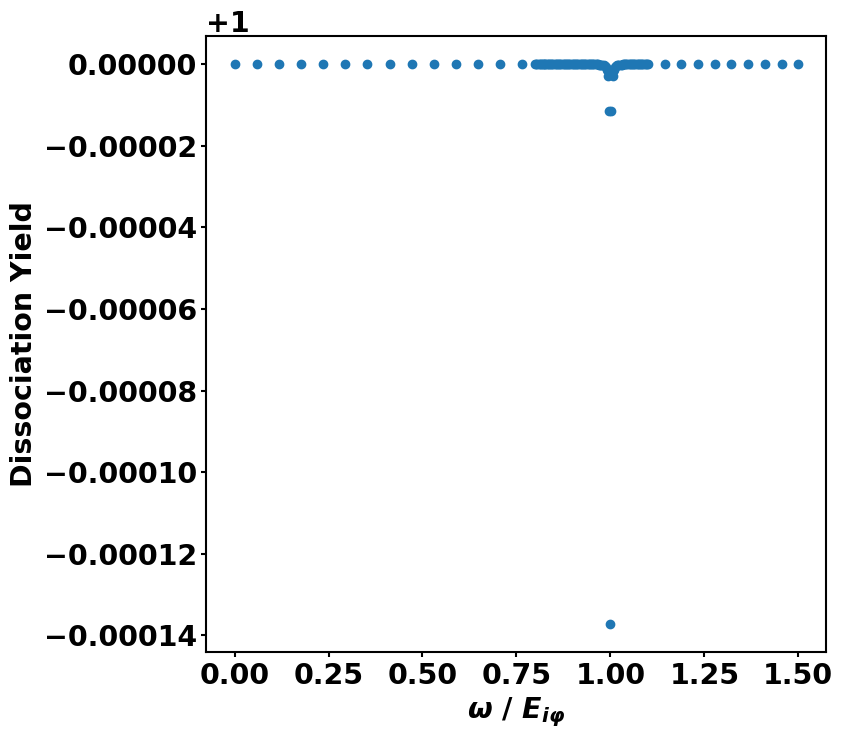

Starting spectrum simulation for g=0 a.u., dt=0.0003 ns and gamma_diss=7499.999999999999 cm^-1
Detuning E_phi not set to 0


100%|██████████| 125/125 [00:00<00:00, 1289.36it/s]


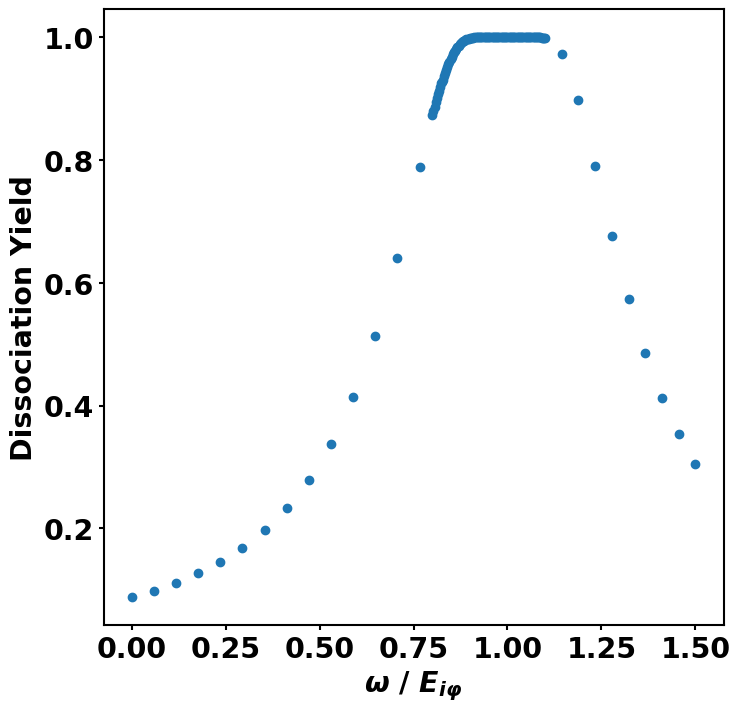

Detuning E_phi set to 0


100%|██████████| 125/125 [00:00<00:00, 1287.73it/s]


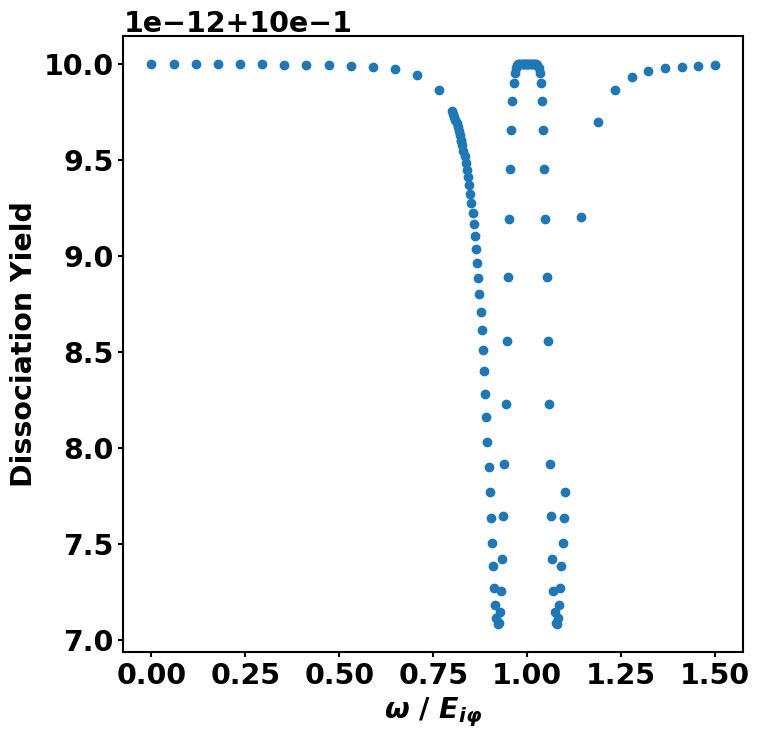

In [13]:
# Make two more simulations for different gamma_diss, setting the detuning to 0 or not

Gamma_diss = 10*1e2 * pc["atomic unit of length"][0] # cm^-1
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns and gamma_diss={Gamma_diss / pc["atomic unit of length"][0]} cm^-1')
print('Detuning E_phi not set to 0')
simulate_plot_spectrum(g_phipsi, omega_range, mod_gamma_diss=True)
print('Detuning E_phi set to 0')
simulate_plot_spectrum(g_phipsi, omega_range, E_psi_zero=True, mod_gamma_diss=True)
Gamma_diss = 75*1e2 * pc["atomic unit of length"][0] # cm^-1
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns and gamma_diss={Gamma_diss / pc["atomic unit of length"][0]} cm^-1')
print('Detuning E_phi not set to 0')
simulate_plot_spectrum(g_phipsi, omega_range, mod_gamma_diss=True)
print('Detuning E_phi set to 0')
simulate_plot_spectrum(g_phipsi, omega_range, E_psi_zero=True, mod_gamma_diss=True)

# Reset gamma_diss
Gamma_diss = 25*1e2 * pc["atomic unit of length"][0] # cm^-1


The second result is weird. A larger $\Gamma_{diss}$ should lead to a larger dissociation yield, but not change the dependence on $\omega$...

I do not see how these spectra should fit together, that does not at all make sense to me!

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=0.0 a.u., gamma_diss=1.3229430272575e-07 a.u.
Dissociation Yield: 0.9999999999999999


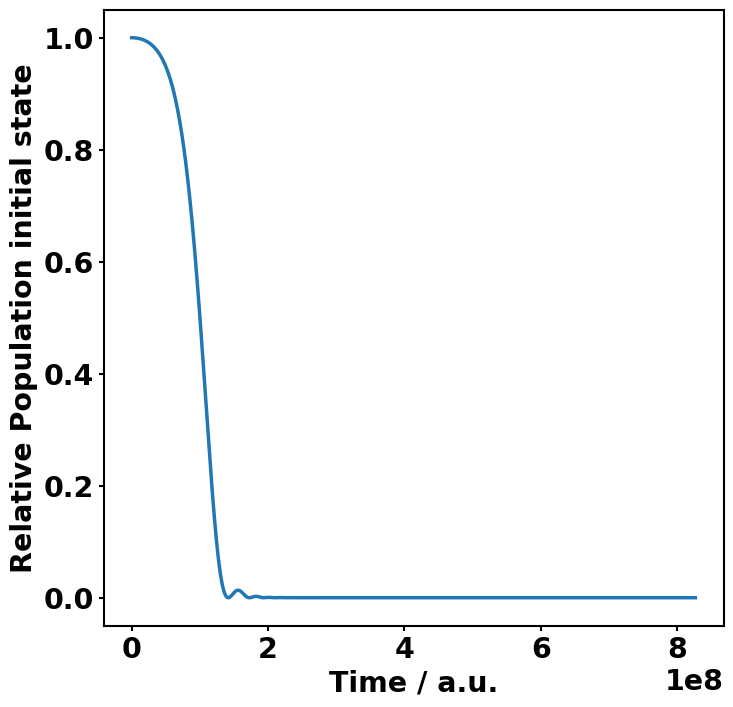

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=0.8787878787878789 a.u., gamma_diss=1.3229430272575e-07 a.u.
Dissociation Yield: 0.9999999999982888


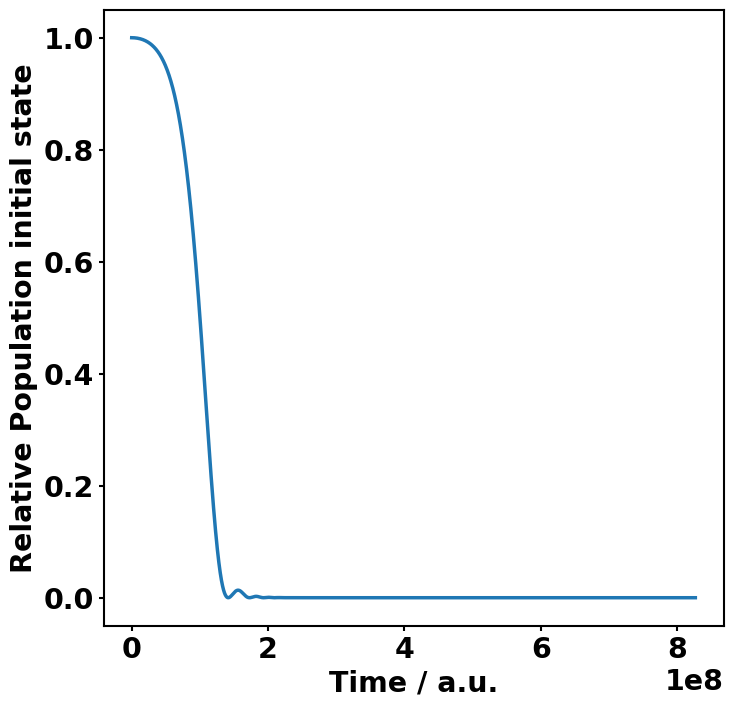

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=0.9424242424242425 a.u., gamma_diss=1.3229430272575e-07 a.u.
Dissociation Yield: 0.9999999999866588


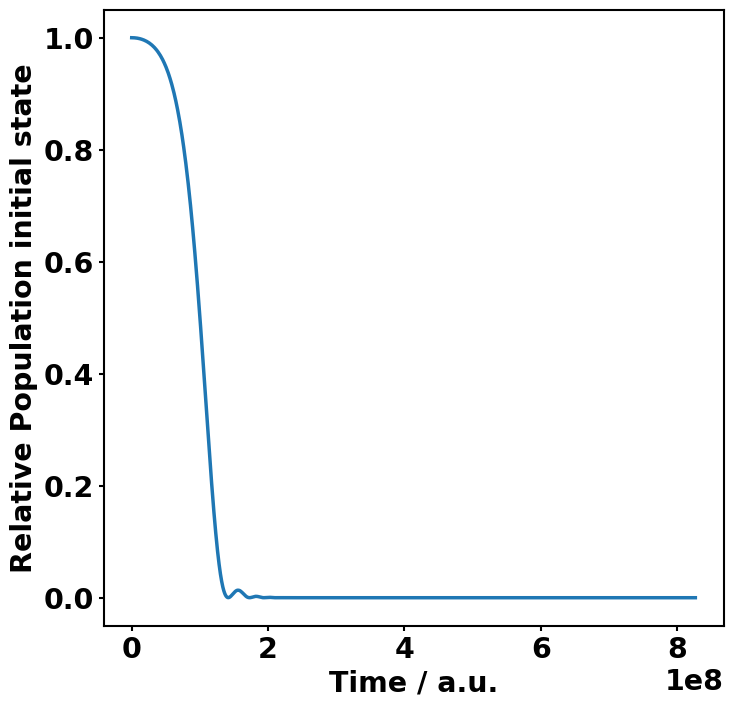

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=1.0030303030303032 a.u., gamma_diss=1.3229430272575e-07 a.u.
Dissociation Yield: 0.9999999999234973


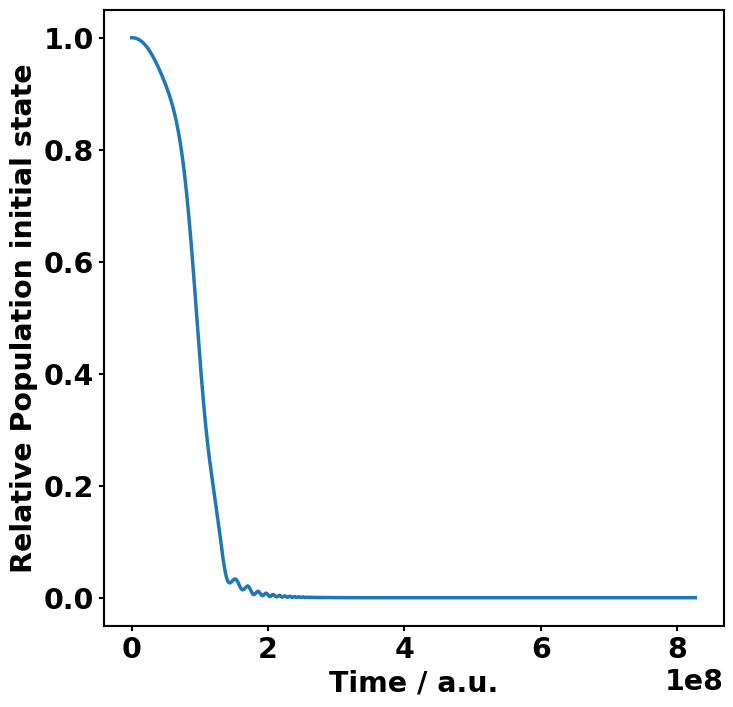

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=1.0 a.u., gamma_diss=1.3229430272575e-07 a.u.
Dissociation Yield: 0.999999994291585


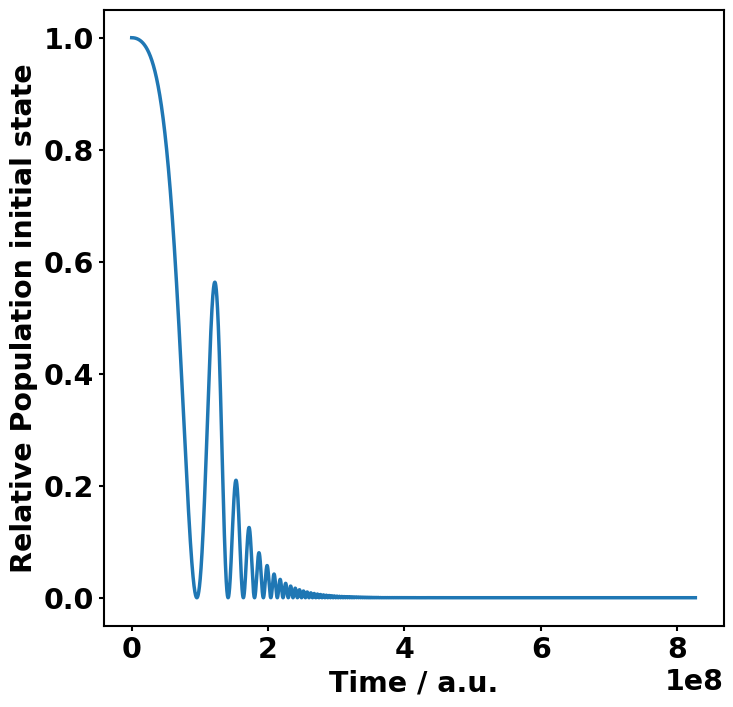

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=1.5 a.u., gamma_diss=1.3229430272575e-07 a.u.
Dissociation Yield: 0.9999999999999937


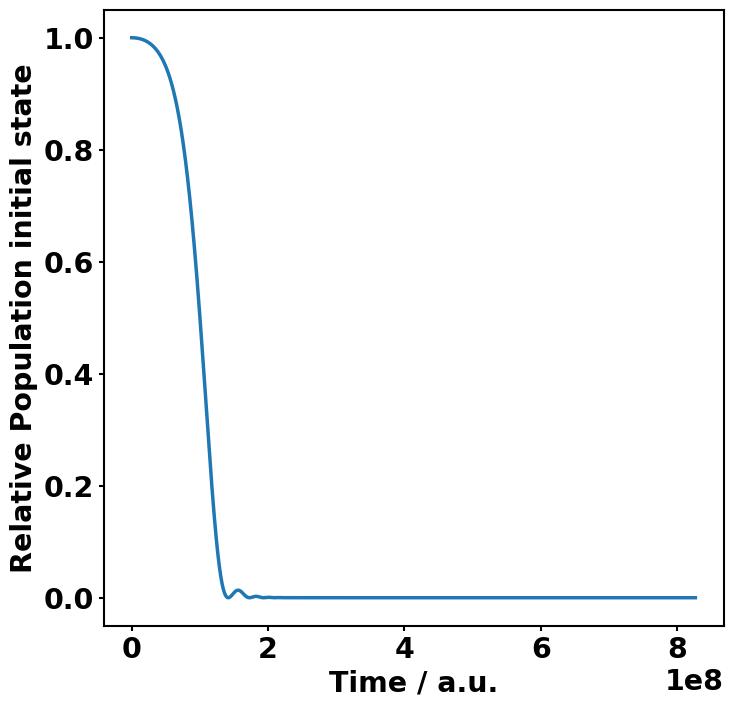

In [14]:
# Check again if for detuning=0 the results are stable
omega_check_range = [omega_range[0], omega_range[len(omega_range)//3], omega_range[len(omega_range)//2], omega_range[len(omega_range)//3*2], E_i_phi, omega_range[-1]]
for omega in omega_check_range:
    print(f'Showing plots for X for detuning=0, g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns, omega/E_iphi={omega/E_i_phi} a.u., gamma_diss={Gamma_diss} a.u.')
    with h5py.File(os.path.join(X_cache_dir, f'dt_{round(dt)}', f'g_{g_phipsi}', f'omega_{str(omega*1e10)}_E_psi_zero.h5'), 'r') as hf:
        X = hf['X'][:]
        t_range = np.linspace(0, T, int(T/dt))
        print(f'Dissociation Yield: {1-np.abs(X[-1,0])**2}')
        plt.plot(t_range, np.abs(X[:,0])**2, label=r'$\omega / E_{i, \varphi} = 1$')
        plt.xlabel('Time / a.u.')
        plt.ylabel('Relative Population initial state')
        plt.show()


Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=0.0 a.u., gamma_diss=7499.999999999999 a.u.


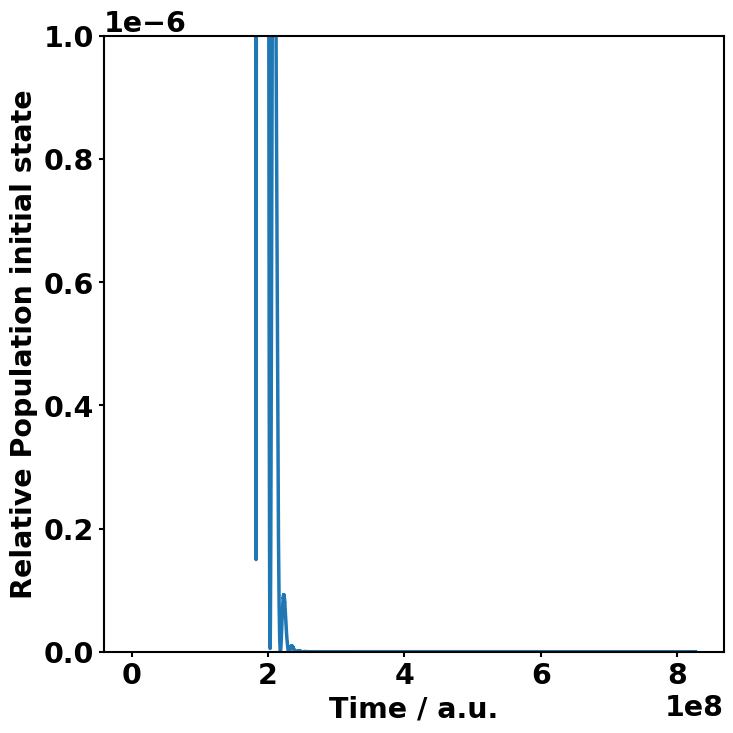

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=0.8787878787878789 a.u., gamma_diss=7499.999999999999 a.u.


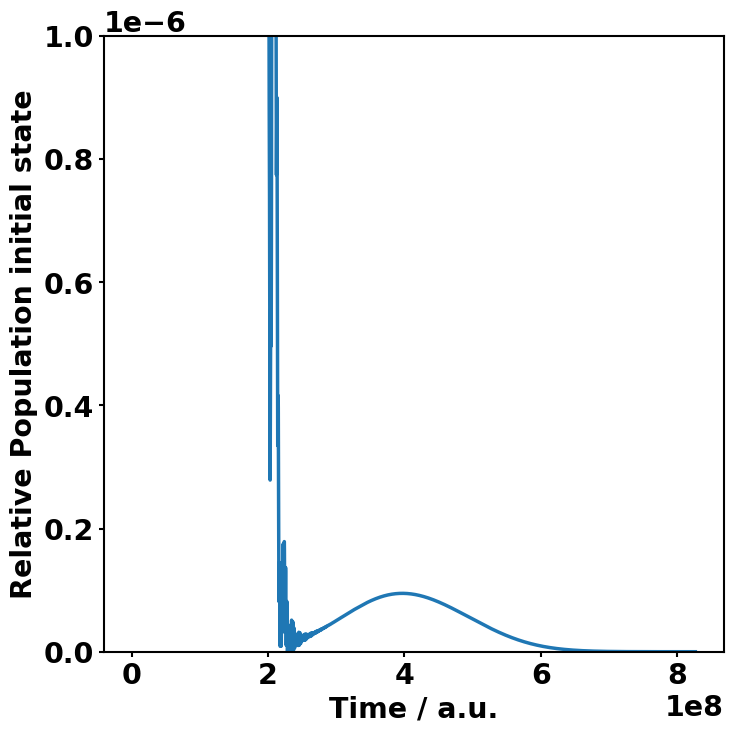

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=0.9424242424242425 a.u., gamma_diss=7499.999999999999 a.u.


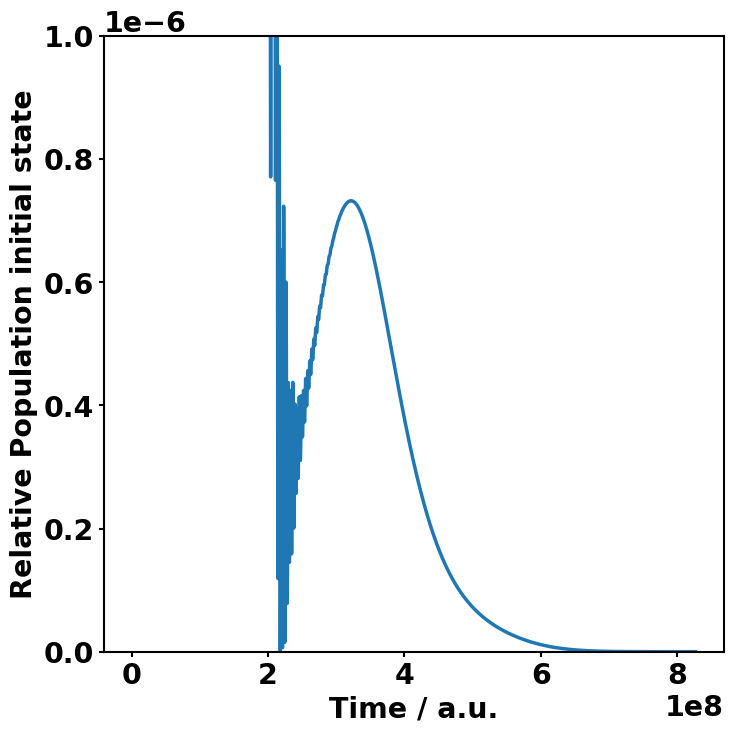

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=1.0030303030303032 a.u., gamma_diss=7499.999999999999 a.u.


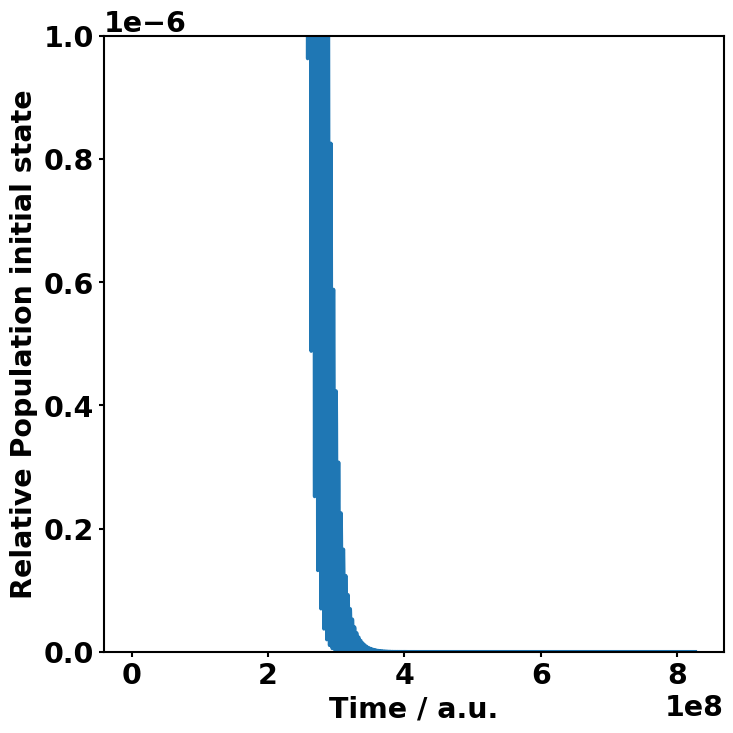

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=1.0 a.u., gamma_diss=7499.999999999999 a.u.


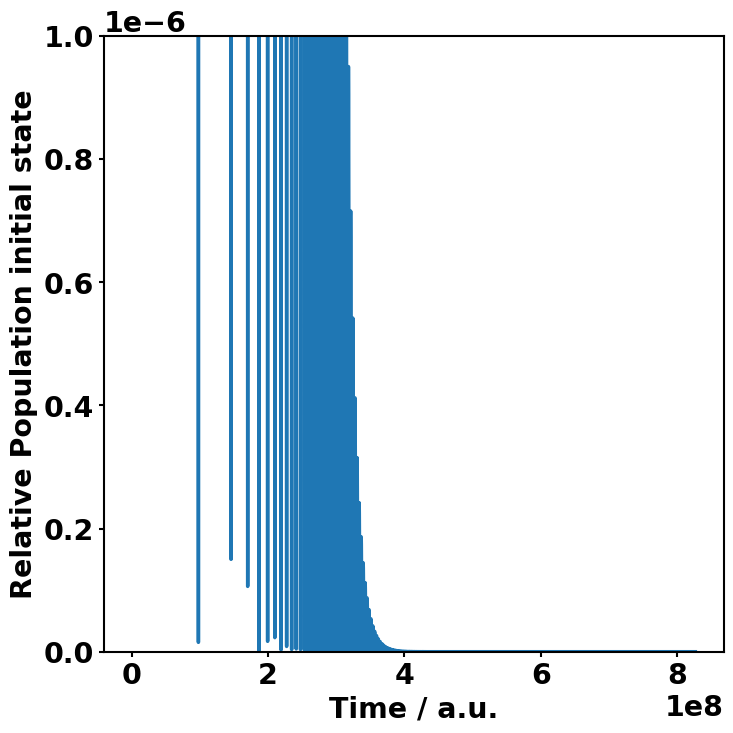

Showing plots for X for detuning=0, g=0 a.u., dt=0.0003 ns, T=20.0 ns, omega/E_iphi=1.5 a.u., gamma_diss=7499.999999999999 a.u.


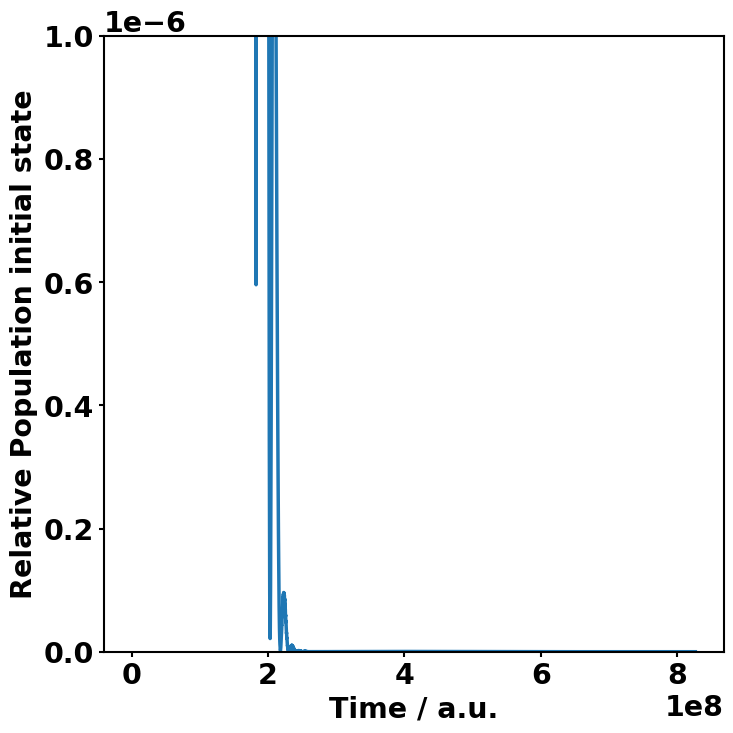

In [15]:
# Same thing for gamma_diss at 75 cm^-1
Gamma_diss = 75*1e2 * pc["atomic unit of length"][0] # cm^-1
for omega in omega_check_range:
    print(f'Showing plots for X for detuning=0, g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns, omega/E_iphi={omega/E_i_phi} a.u., gamma_diss={Gamma_diss / pc["atomic unit of length"][0]} a.u.')
    with h5py.File(os.path.join(X_cache_dir, f'dt_{round(dt)}', f'g_{g_phipsi}', f'omega_{str(omega*1e10)}_E_psi_zero_gamma_{Gamma_diss}.h5'), 'r') as hf:
        X = hf['X'][:]
        t_range = np.linspace(0, T, int(T/dt))
        plt.plot(t_range, np.abs(X[:,0])**2, label=r'$\omega / E_{i, \varphi} = 1$')
        plt.ylim(0, 1e-6)
        plt.xlabel('Time / a.u.')
        plt.ylabel('Relative Population initial state')
        plt.show()
# Reset gamma_diss
Gamma_diss = 25*1e2 * pc["atomic unit of length"][0] # cm^-1

Perhaps the time evolution is not carried out long enough, let's try with $T = 100$ ns.

In [16]:
# # Test with T=100 ns
# T = 100e-9 / aut # ns
# Gamma_diss = 75*1e2 * pc["atomic unit of length"][0] # cm^-1
# print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns')
# simulate_plot_spectrum(g_phipsi, omega_range)
# print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns and detuning E_psi=0')
# simulate_plot_spectrum(0, omega_range, E_psi_zero=True)
# # Reset T, gamma_diss
# T = 20e-9 / aut # ns
# Gamma_diss = 25*1e2 * pc["atomic unit of length"][0] # cm^-1

Just another artefact then, the state fully dissociates if we set the detuning to 0. This is also the only thing that makes sense, as the continuum is excited even when the laser is turned off and in equilibrium all population is lost. I don't understand how to interpret the tasks given in the project script.

Starting spectrum simulation for g=1e-07 a.u., dt=0.0003 ns, T=20.0 ns


100%|██████████| 125/125 [00:00<00:00, 1270.11it/s]


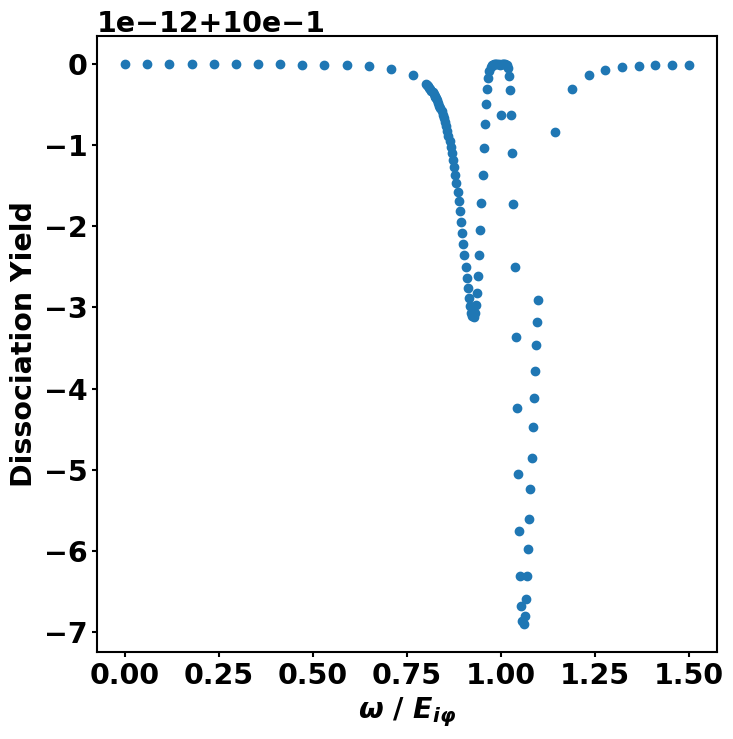

In [17]:
# From now on always work with detuning E_psi=0??? (Doesn't make sense, but is stated in the task)

Gamma_diss = 50*1e2 * pc["atomic unit of length"][0] # cm^-1

# Include g_phipsi
g_phipsi = 1e-7 # au
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns')
simulate_plot_spectrum(g_phipsi, omega_range, E_psi_zero=True)
# Reset gamma_diss
Gamma_diss = 25*1e2 * pc["atomic unit of length"][0] # cm^-1

Now we finally obtain something asymmetric. However if I would let the simulation run longer, the population would be lost at any frequency, as the continuum can be excited at any frequency. There definitely is something off with my interpretation of turning the detuning to 0.

Starting spectrum simulation for g=7.5e-06 a.u., dt=0.0003 ns, T=20.0 ns


100%|██████████| 125/125 [00:00<00:00, 688.84it/s]


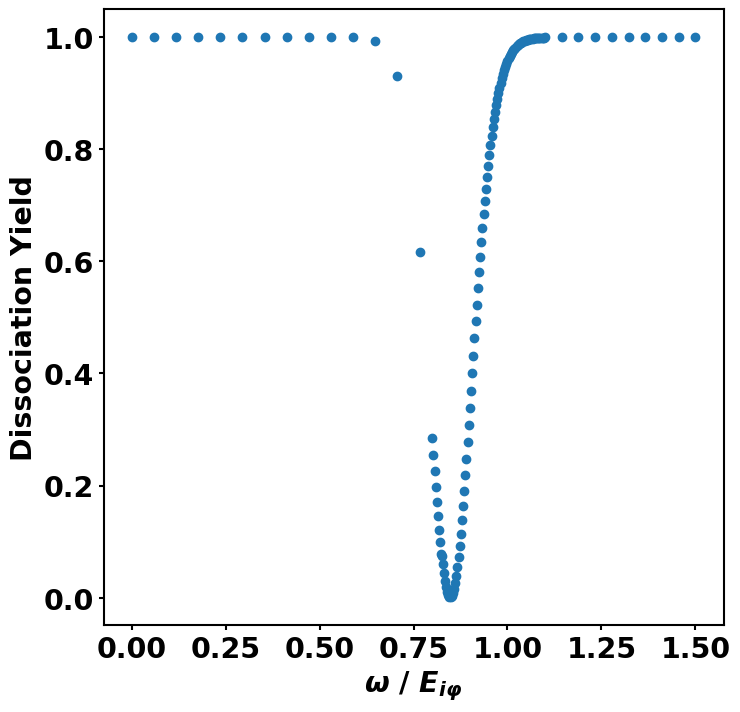

Starting spectrum simulation for g=5e-06 a.u., dt=0.0003 ns, T=20.0 ns


100%|██████████| 125/125 [00:00<00:00, 541.99it/s]


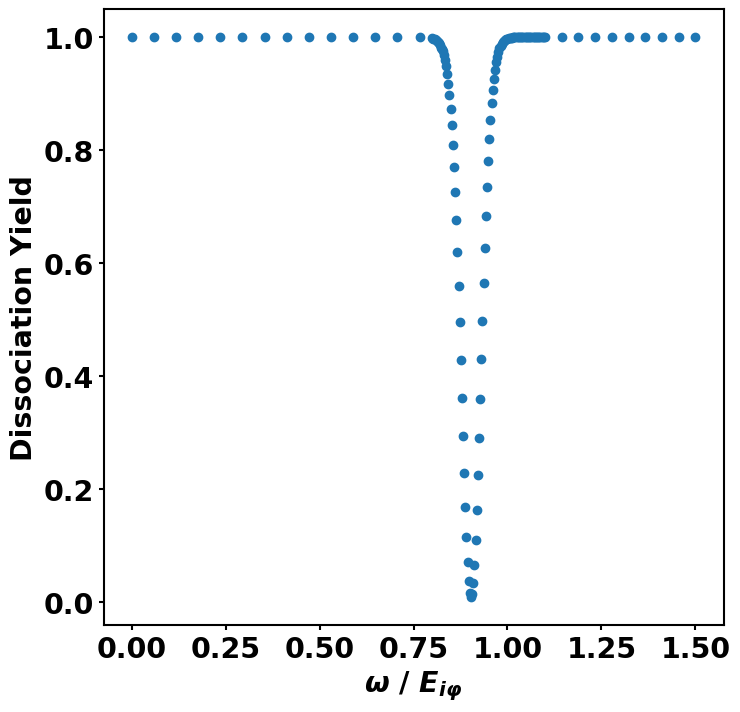

In [18]:
Gamma_diss = 50*1e2 * pc["atomic unit of length"][0] # cm^-1

# Repeat for different values of g_phipsi
g_phipsi = 7.5e-6 # au
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns')
simulate_plot_spectrum(g_phipsi, omega_range, E_psi_zero=True)

g_phipsi = 5e-6 # au
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns')
simulate_plot_spectrum(g_phipsi, omega_range, E_psi_zero=True)
# Reset gamma_diss
Gamma_diss = 25*1e2 * pc["atomic unit of length"][0] # cm^-1

In [19]:
# Show the relation between the q parameter and the resonance linewidth Gamma_res to g_phipsi and Gamma_diss

In [49]:
# It does not really make sense to me to set the detuning of the continuum to 0, so let's not do it and try out different g_phipsi and Gamma_diss values
Gamma_diss = 50*1e2 * pc["atomic unit of length"][0] # cm^-1
for g_phipsi in [1e-7, 5e-6]: # au
    print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns, gamma_diss={Gamma_diss} a.u.')
    simulate_plot_spectrum(g_phipsi, omega_range)


g_phipsi = 1e-7 # au
for Gamma_diss in [75*1e2 * pc["atomic unit of length"][0], 25*1e2 * pc["atomic unit of length"][0]]: # cm^-1
    print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns, gamma_diss={Gamma_diss} a.u.')
    simulate_plot_spectrum(g_phipsi, omega_range)

Starting spectrum simulation for g=1e-07 a.u., dt=0.0003 ns, T=20.0 ns, gamma_diss=2.645886054515e-07 a.u.


 31%|███       | 39/125 [00:41<01:30,  1.05s/it]


Starting spectrum simulation for g=5e-06 a.u., dt=0.0003 ns, T=20.0 ns, gamma_diss=2.645886054515e-07 a.u.


100%|██████████| 80/80 [01:19<00:00,  1.01it/s]


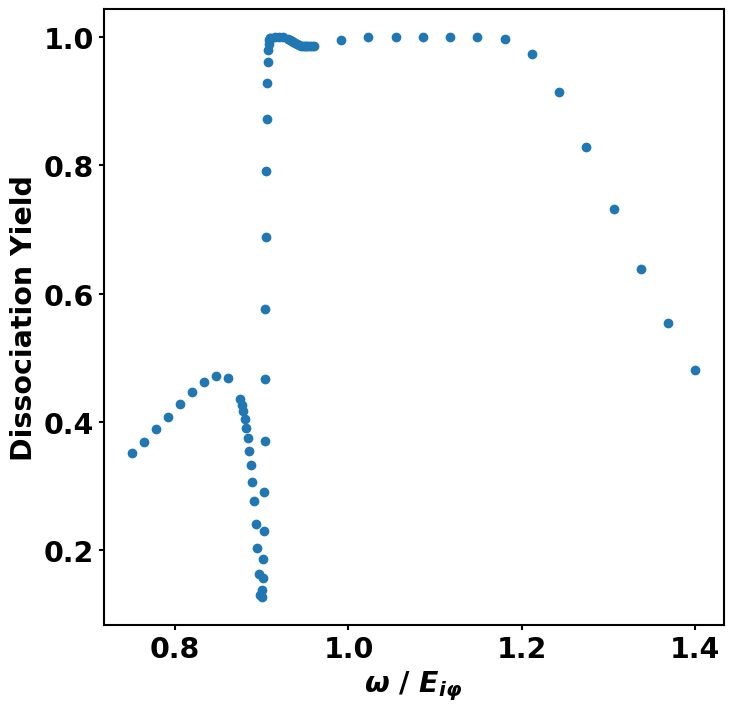

In [31]:
# Now we need to improve the omega range to get the correct resolution
omega_range_zoom = np.concatenate([
    np.linspace(0.75*E_i_phi, 0.875*E_i_phi, 10),
    np.linspace(0.875*E_i_phi, 0.9*E_i_phi, 15),
    np.linspace(0.9*E_i_phi, 0.91*E_i_phi, 20),
    np.linspace(0.91*E_i_phi, 0.93*E_i_phi, 5),
    np.linspace(0.93*E_i_phi, 0.96*E_i_phi, 15),
    np.linspace(0.96*E_i_phi, 1.4*E_i_phi, 15)
])

# Check the results for the new omega range
g_phipsi = 5e-6 # au
Gamma_diss = 50*1e2 * pc["atomic unit of length"][0] # cm^-1
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns, gamma_diss={Gamma_diss} a.u.')
simulate_plot_spectrum(g_phipsi, omega_range_zoom)

Starting spectrum simulation for g=5e-06 a.u., dt=0.0003 ns, T=20.0 ns, gamma_diss=5.29177210903e-08 a.u.


100%|██████████| 80/80 [01:17<00:00,  1.03it/s]


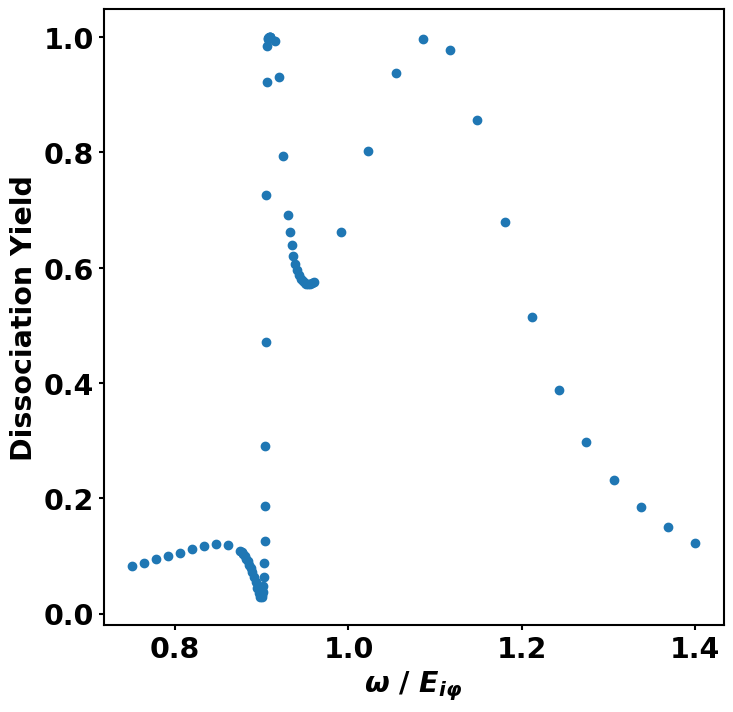

In [24]:
# Same for a smaller Gamma_diss
Gamma_diss = 10*1e2 * pc["atomic unit of length"][0] # cm^-1
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns, gamma_diss={Gamma_diss} a.u.')
simulate_plot_spectrum(g_phipsi, omega_range_zoom)

Starting spectrum simulation for g=5e-06 a.u., dt=0.0003 ns, T=20.0 ns, gamma_diss=5.29177210903e-08 a.u.


100%|██████████| 62/62 [00:59<00:00,  1.04it/s]


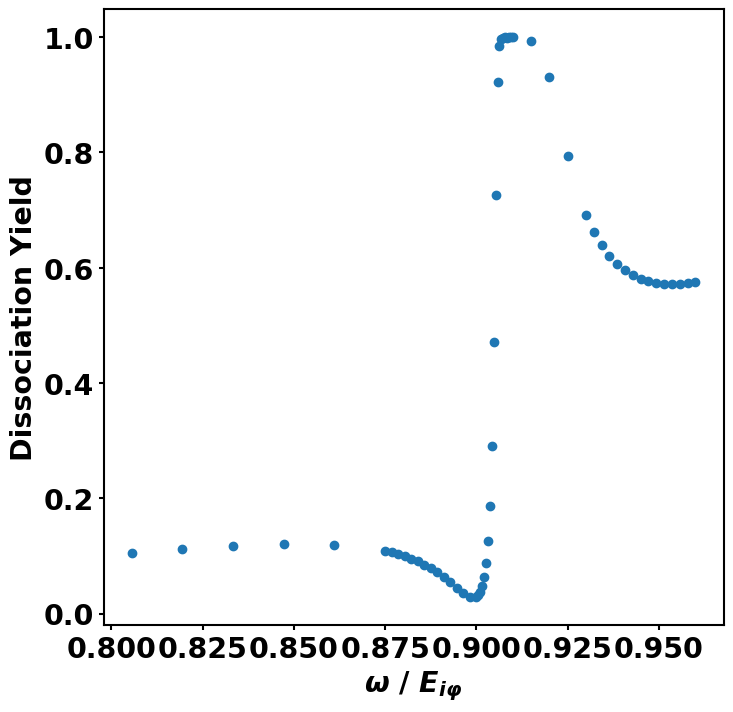

In [33]:
# Zoom further into the relevant region
Gamma_diss = 10*1e2 * pc["atomic unit of length"][0] # cm^-1
print(f'Starting spectrum simulation for g={g_phipsi} a.u., dt={dt*aut*1e9} ns, T={T*aut*1e9} ns, gamma_diss={Gamma_diss} a.u.')
zoom_mask = (omega_range_zoom > 0.8*E_i_phi) & (omega_range_zoom < 0.99*E_i_phi)
simulate_plot_spectrum(g_phipsi, omega_range_zoom[zoom_mask])

  0%|          | 0/62 [00:00<?, ?it/s]

100%|██████████| 62/62 [00:00<00:00, 164.52it/s]


[0.10570139812528567, 0.11157592470086275, 0.11675795906522612, 0.12013583202213052, 0.11931761717339129, 0.10863349459716742, 0.105956387076385, 0.10284822750448741, 0.09925159762141966, 0.09510163208743538, 0.0903261378048309, 0.084847024285023, 0.078584546037335, 0.07146751001620089, 0.06345629688110255, 0.054594282273707107, 0.045125404830183125, 0.03577714487246897, 0.02850052372018197, 0.02866682279631938, 0.03196538026572482, 0.0379286791450959, 0.04774949433591802, 0.06327910625898647, 0.08751889714446837, 0.12562297332921568, 0.1871667353428087, 0.29118482603336493, 0.4712216046256552, 0.7258608819076136, 0.9216217610863031, 0.9850704790676881, 0.9964093042257918, 0.9991706929385564, 0.9995017314681495, 0.9992552998500606, 0.9999764411504358, 0.9994116469586606, 0.999678303158213, 0.9929991655667736, 0.9311812839987725, 0.7935526232472565, 0.69136972824044, 0.6618804361656562, 0.6387525116665214, 0.620654133319617, 0.6065471484433406, 0.5956396553316367, 0.5873291204818787, 0.

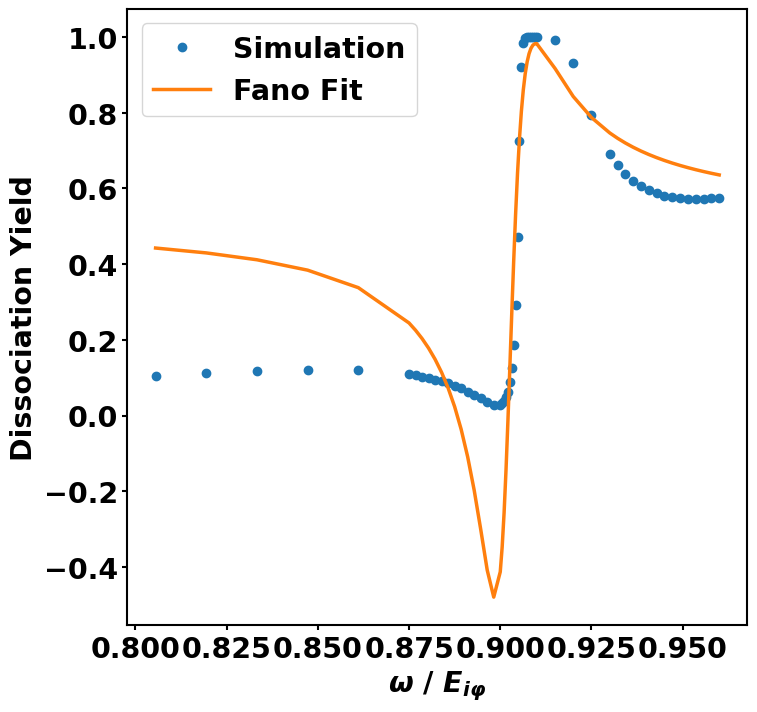

100%|██████████| 300/300 [00:03<00:00, 98.68it/s] 


[0.10329127648594516, 0.10350917225853329, 0.10372705989113284, 0.10394492575503211, 0.1041627559375482, 0.10438053610386233, 0.10459825153091007, 0.1048158872147712, 0.10503342777787572, 0.10525085737273165, 0.10546815978801083, 0.10568531848496387, 0.10590231645488346, 0.10611913621018743, 0.10633575990641919, 0.10655216928280442, 0.10676834553482373, 0.1069842693942814, 0.10719992120130784, 0.10741528076922957, 0.107630327333186, 0.10784503967560322, 0.10805939610117676, 0.10827337428830797, 0.10848695133733222, 0.10870010386952611, 0.10891280790671787, 0.10912503878179836, 0.1093367712576333, 0.10954797953521667, 0.10975863709190958, 0.10996871669520047, 0.11017819052026834, 0.11038703004894435, 0.11059520594613126, 0.11080268816520533, 0.11100944598623241, 0.11121544784692416, 0.11142066132082307, 0.11162505324640581, 0.11182858964680131, 0.11203123557674688, 0.11223295520854526, 0.11243371189648022, 0.11263346800522789, 0.11283218485122148, 0.11302982283783025, 0.1132263413956043

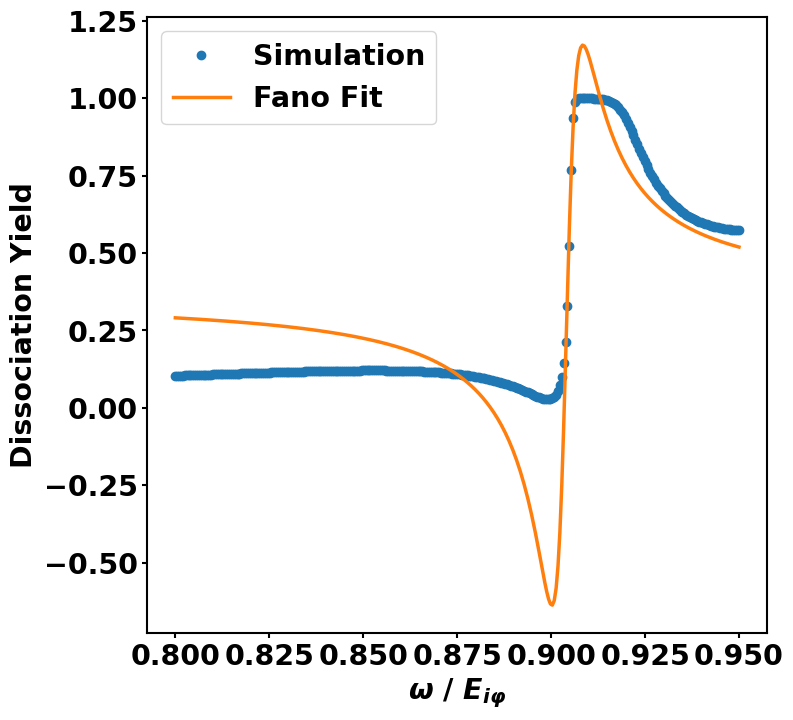

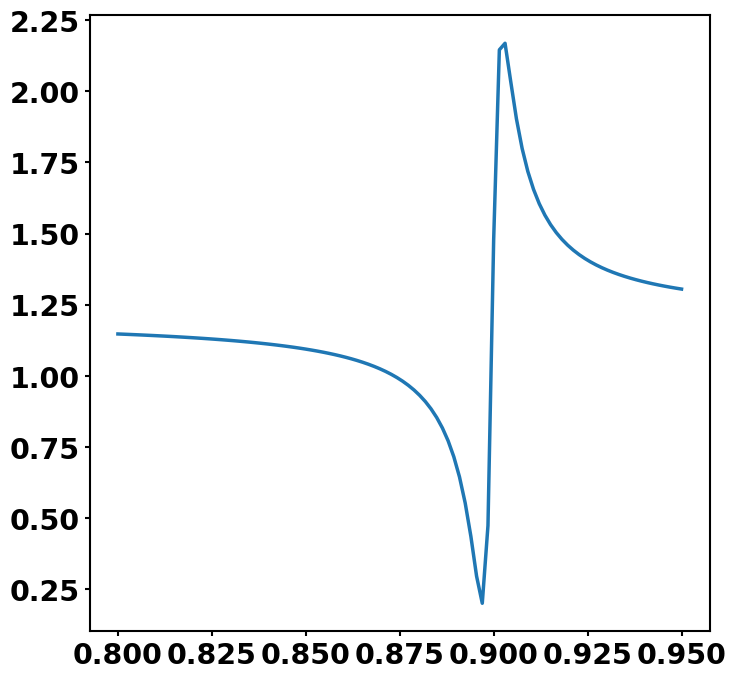

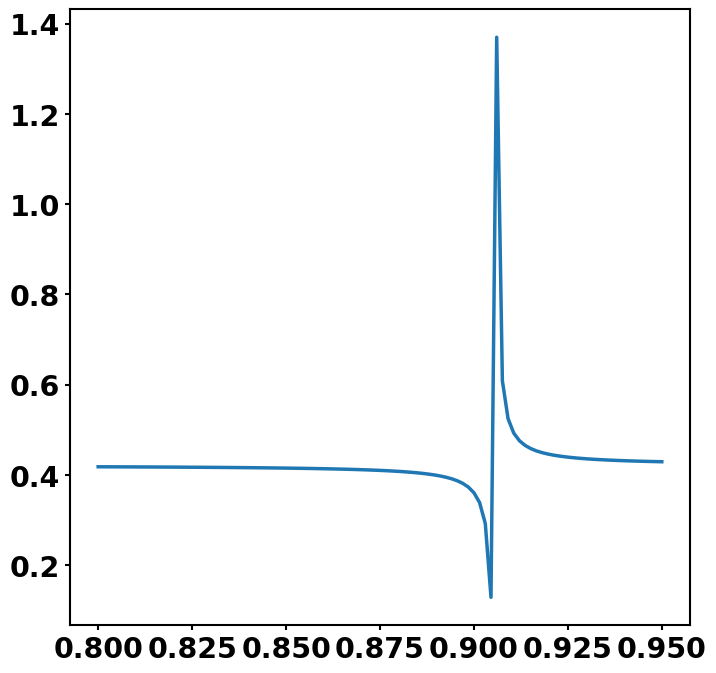

In [200]:
num_threads_max=1
# Fit the Fano line shape
simulate_plot_spectrum(g_phipsi, omega_range_zoom[zoom_mask], fit_fano=True)
omega_range_fit = np.linspace(0.8*E_i_phi, 0.95*E_i_phi, 300)
simulate_plot_spectrum(g_phipsi, omega_range_fit, fit_fano=True)
x = np.linspace(0.8*E_i_phi, 0.95*E_i_phi, 100)
plt.plot(x/E_i_phi, fano(x/E_i_phi, q=1, gamma_res=Gamma_diss*1e5, omega_res=34000.9*E_i_phi, c=0.2))
plt.show()
x = np.linspace(0.8*E_i_phi, 0.95*E_i_phi, 100)
plt.plot(x/E_i_phi, fano(x/E_i_phi, q=1.75439132836561, gamma_res=0.00019842069190185904, omega_res=0.9056640945292885, c=-0.5786389533064435))
plt.show()